# Stock Prediction Analysis using LSTM and GRU 

## Stock Price Action: 
Open, High, Low, Close, Adjust close ,Trade Volume

## Stock Probability analysis data: 
RSI, MACD, Bollinger, DMA, Volume Delta, Rate change 

## economy data:
Unemployment rate and Price index per Month

## News data: 
Last 100 News per each stock with analyzer of the good whether it's good or bad 

## Analyzed stocks:
- AAPl
- AZN
- BA
- DIS
- JPM
- MSFT
- NVDA
- PFE
- TSLA
- WMT 


In [32]:
# Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import yfinance as yf
import numpy as np
from stockstats import StockDataFrame as Sdf
import pandas as pd 
import quandl
import matplotlib
import matplotlib.pyplot as plt
import warnings
from math import sqrt
import copy
from numpy import split, array
import datetime as dt
import time
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from matplotlib.pyplot import figure
import random as rn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow.compat.v2 as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
plt.style.use('ggplot')
quandl.ApiConfig.api_key = "tgJvn_S9mLsWRyVsbMzy"

In [33]:
unemployment = quandl.get(["FRED/UNRATE"],
    trim_start="2015-01-01", trim_end="2020-11-01", collapse = 'monthly')
unemployment.columns = ['Unemployment']
Price_index = quandl.get(["FRED/CUUR0000SA0R"],\
    trim_start="2015-01-01", trim_end="2020-12-01", collapse = 'monthly')
Price_index.columns = ['Consumer Price Index']

##### AAPL_data = yf.download('AAPL','2015-01-01','2020-12-01')

In [34]:
AAPL_data = yf.download('AAPL','2015-01-01','2020-12-01')
AAPL_data = AAPL_data.dropna()
AAPL_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.696352,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,24.000614,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,24.002876,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.339447,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.274624,237458000
...,...,...,...,...,...,...
2020-11-23,117.180000,117.620003,113.750000,113.849998,113.849998,127959300
2020-11-24,113.910004,115.849998,112.589996,115.169998,115.169998,113874200
2020-11-25,115.550003,116.750000,115.169998,116.029999,116.029999,76499200


In [35]:
AAPL_data=Sdf.retype(AAPL_data)
AAPL_data['macd']=AAPL_data['macd'] #macd s is 26 avr and h is 12 ave
AAPL_data['boll']=AAPL_data['boll'] #upper boll
AAPL_data['boll_lb']=AAPL_data['boll_lb'] #middle STD
AAPL_data['boll_lb']=AAPL_data['boll_lb'] #lower boll
AAPL_data['volume_delta']=AAPL_data['volume_delta'] #volume compared to yesterday
AAPL_data['dma']=AAPL_data['dma'] #diff between 10 and 50 moving avg
AAPL_data['close_-1_r'] = AAPL_data['close_-1_r']  #price change in rate

AAPL_data = pd.concat([Price_index,unemployment, AAPL_data], axis=1)
AAPL_data = AAPL_data.fillna(method='ffill')
AAPL_data = AAPL_data.fillna(method='bfill')
AAPL_data = AAPL_data.iloc[3:]

In [36]:
AAPL_data

,Consumer Price Index,Unemployment,open,high,low,close,adj close,volume,macd,macds,...,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,volume_delta,close_10_sma,close_50_sma,dma,close_-1_r
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,42.8,5.7,26.799999,27.049999,26.674999,26.937500,24.339447,160423600.0,-0.010068,-0.013100,...,26.849375,0.367125,26.849375,27.583625,26.115125,-102764800.0,26.849375,26.849375,0.000000,1.402219
2015-01-08,42.8,5.7,27.307501,28.037500,27.174999,27.972500,25.274624,237458000.0,0.037778,0.002035,...,27.074000,0.594447,27.074000,28.262894,25.885106,77034400.0,27.074000,27.074000,0.000000,3.842227
2015-01-09,42.8,5.7,28.167500,28.312500,27.552500,28.002501,25.301731,214798000.0,0.067112,0.019674,...,27.228750,0.652977,27.228750,28.534705,25.922796,-22660000.0,27.228750,27.228750,0.000000,0.107251
2015-01-12,42.8,5.7,28.150000,28.157499,27.200001,27.312500,24.678280,198603200.0,0.053510,0.028237,...,27.240714,0.596924,27.240714,28.434562,26.046867,-16194800.0,27.240714,27.240714,0.000000,-2.464068
2015-01-13,42.8,5.7,27.857500,28.200001,27.227501,27.555000,24.897392,268367600.0,0.055063,0.034684,...,27.280000,0.563704,27.280000,28.407409,26.152592,69764400.0,27.280000,27.280000,0.000000,0.887873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,38.4,6.9,117.180000,117.620003,113.750000,113.849998,113.849998,127959300.0,0.488706,0.651289,...,116.082999,3.671484,116.082999,123.425967,108.740032,54567900.0,118.148000,115.399800,2.748200,-2.974261
2020-11-24,38.4,6.9,113.910004,115.849998,112.589996,115.169998,115.169998,113874200.0,0.289593,0.578949,...,116.011499,3.674808,116.011499,123.361116,108.661883,-14085100.0,118.067999,115.392400,2.675600,1.159420
2020-11-25,38.4,6.9,115.550003,116.750000,115.169998,116.029999,116.029999,76499200.0,0.198897,0.502939,...,116.252999,3.496340,116.252999,123.245679,109.260320,-37375000.0,117.721999,115.470400,2.251600,0.746723


In [37]:
# plotting setup 
plt.style.use("seaborn-darkgrid")
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["figure.figsize"] = (18, 10)

## Stock Prediction Using LSTM 

In [38]:
# data preprocessing 
data = copy.deepcopy(AAPL_data)
data = data.fillna(0) # removing NaN from columns
data = data.drop(['volume','volume_delta'],1)
data.insert(6, 'daily_return', data.close.pct_change().fillna(0))
data.insert(7, 'cum_daily_return',(1 + data['daily_return']).cumprod())
#data.info()
#data.index
#data
values = data.values
values = values.astype('float32')

values =pd.DataFrame(values)
#values.head()
data


,Consumer Price Index,Unemployment,open,high,low,close,daily_return,cum_daily_return,adj close,macd,...,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,close_10_sma,close_50_sma,dma,close_-1_r
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,42.8,5.7,26.799999,27.049999,26.674999,26.937500,0.000000,1.000000,24.339447,-0.010068,...,0.003033,26.849375,0.367125,26.849375,27.583625,26.115125,26.849375,26.849375,0.000000,1.402219
2015-01-08,42.8,5.7,27.307501,28.037500,27.174999,27.972500,0.038422,1.038422,25.274624,0.037778,...,0.035743,27.074000,0.594447,27.074000,28.262894,25.885106,27.074000,27.074000,0.000000,3.842227
2015-01-09,42.8,5.7,28.167500,28.312500,27.552500,28.002501,0.001073,1.039536,25.301731,0.067112,...,0.047438,27.228750,0.652977,27.228750,28.534705,25.922796,27.228750,27.228750,0.000000,0.107251
2015-01-12,42.8,5.7,28.150000,28.157499,27.200001,27.312500,-0.024641,1.013921,24.678280,0.053510,...,0.025273,27.240714,0.596924,27.240714,28.434562,26.046867,27.240714,27.240714,0.000000,-2.464068
2015-01-13,42.8,5.7,27.857500,28.200001,27.227501,27.555000,0.008879,1.022923,24.897392,0.055063,...,0.020379,27.280000,0.563704,27.280000,28.407409,26.152592,27.280000,27.280000,0.000000,0.887873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,38.4,6.9,117.180000,117.620003,113.750000,113.849998,-0.029743,4.226450,113.849998,0.488706,...,-0.162583,116.082999,3.671484,116.082999,123.425967,108.740032,118.148000,115.399800,2.748200,-2.974261
2020-11-24,38.4,6.9,113.910004,115.849998,112.589996,115.169998,0.011594,4.275452,115.169998,0.289593,...,-0.289356,116.011499,3.674808,116.011499,123.361116,108.661883,118.067999,115.392400,2.675600,1.159420
2020-11-25,38.4,6.9,115.550003,116.750000,115.169998,116.029999,0.007467,4.307378,116.029999,0.198897,...,-0.304042,116.252999,3.496340,116.252999,123.245679,109.260320,117.721999,115.470400,2.251600,0.746723


In [41]:
# create time series 
def ts (a, look_back = 60, pred_col = 6):
    t = a.copy()
    t["id"] = range(1, len(t)+1)
    t = t.iloc[:-look_back, :]
    t.set_index('id', inplace =True)
    pred_value = a.copy()
    pred_value = pred_value.iloc[look_back:, pred_col]
    pred_value.columns = ["Pred"]
    pred_value = pd.DataFrame(pred_value)
    pred_value["id"] = range(1, len(pred_value)+1)
    pred_value.set_index('id', inplace = True)
    final_df= pd.concat([t, pred_value], axis=1)    
    return final_df
arr_df = ts(values, 60,6)
arr_df.fillna(0, inplace=True)

arr_df.columns = ['v1(t-60)', 'v2(t-60)', 'v3(t-60)', 'v4(t-60)', 
                       'v5(t-60)', 'v6(t-60)', 'v7(t-60)', 'v8(t-60)',
                       'v9(t-60)', 'v10(t-60)', 'v11(t-60)', 'v12(t-60)',
                       'v13(t-60)', 'v14(t-60)', 'v15(t-60)', 'v16(t-60)',
                       'v17(t-60)', 'v18(t-60)', 'v19(t-60)','v20(t-60)','v21(t-60)', 
                       'v1(t)']
#arr_df.head()
arr_df.shape
# split into train and test 
val = arr_df.values
train_sample =int(len(data)*0.8)
train = val[: train_sample, :]
test = val[train_sample:, :]
#print(train.shape, test.shape)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
X, y = train, test
scaler = MinMaxScaler((1,2))
X= scaler.fit_transform(X)
#print(X.shape)
X_train = []
y_train = []
for i in range(60, X.shape[0]):
    X_train.append(X[i-60:i])
    y_train.append(X[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)
look_back = train.tail(60)
dataset = look_back.append(test)
#dataset
inputs = scaler.transform(dataset)
#inputs
X_test = []
y_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)   
y_test

(1145, 60, 22) (1145,)
(242, 60, 22) (242,)


array([1.        , 1.        , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 ,
       0.9736843 , 0.9736843 , 0.9736843 , 0.9736843 , 0.97368

In [42]:
tf.enable_v2_behavior()
print(tf.__version__) 


2.1.0


In [43]:
# build LSTM model
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(units = 75, return_sequences = True, 
                                   input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units = 30,return_sequences = True))
model_lstm.add(tf.keras.layers.LSTM(units = 30, return_sequences = True))
model_lstm.add(tf.keras.layers.Dense(units = 1))
model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 75)            29400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 30)            12720     
_________________________________________________________________
lstm_11 (LSTM)               (None, 60, 30)            7320      
_________________________________________________________________
dense_4 (Dense)              (None, 60, 1)             31        
Total params: 49,471
Trainable params: 49,471
Non-trainable params: 0
_________________________________________________________________


In [44]:
# fit LSTM model
history_lstm = model_lstm.fit(X_train, y_train, 
                              epochs = 20, 
                              batch_size = 32, 
                              validation_data = (X_test, y_test),  
                              shuffle=False)

Train on 1145 samples, validate on 242 samples
Epoch 1/20
1145/1145 [==============================] - 6s 5ms/sample - loss: 0.3726 - val_loss: 0.0660
Epoch 2/20
1145/1145 [==============================] - 0s 408us/sample - loss: 0.4605 - val_loss: 0.1899
Epoch 3/20
1145/1145 [==============================] - 0s 387us/sample - loss: 0.4454 - val_loss: 0.3320
Epoch 4/20
1145/1145 [==============================] - 0s 388us/sample - loss: 0.3529 - val_loss: 0.3013
Epoch 5/20
1145/1145 [==============================] - 0s 385us/sample - loss: 0.3774 - val_loss: 0.3686
Epoch 6/20
1145/1145 [==============================] - 0s 387us/sample - loss: 0.3399 - val_loss: 0.3669
Epoch 7/20
1145/1145 [==============================] - 0s 388us/sample - loss: 0.3376 - val_loss: 0.3695
Epoch 8/20
1145/1145 [==============================] - 0s 401us/sample - loss: 0.3319 - val_loss: 0.3813
Epoch 9/20
1145/1145 [==============================] - 0s 400us/sample - loss: 0.3221 - val_loss: 0.3758
E

In [45]:
# build GRU model 
model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(75, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(tf.keras.layers.GRU(units=30, return_sequences=True))
model_gru.add(tf.keras.layers.GRU(units=30))
model_gru.add(tf.keras.layers.Dense(units=1))
model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 60, 75)            22275     
_________________________________________________________________
gru_4 (GRU)                  (None, 60, 30)            9630      
_________________________________________________________________
gru_5 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 37,516
Trainable params: 37,516
Non-trainable params: 0
_________________________________________________________________


In [46]:
# fit GRU model
gru_history = model_gru.fit(X_train, y_train, epochs = 20, batch_size = 64, 
                        validation_data = (X_test, y_test), shuffle=False)

Train on 1145 samples, validate on 242 samples
Epoch 1/20
1145/1145 [==============================] - 5s 5ms/sample - loss: 0.6804 - val_loss: 0.2644
Epoch 2/20
1145/1145 [==============================] - 0s 247us/sample - loss: 0.6361 - val_loss: 0.5902
Epoch 3/20
1145/1145 [==============================] - 0s 234us/sample - loss: 0.1335 - val_loss: 0.0606
Epoch 4/20
1145/1145 [==============================] - 0s 226us/sample - loss: 0.4009 - val_loss: 0.3356
Epoch 5/20
1145/1145 [==============================] - 0s 221us/sample - loss: 0.3171 - val_loss: 0.1604
Epoch 6/20
1145/1145 [==============================] - 0s 229us/sample - loss: 0.2738 - val_loss: 0.1451
Epoch 7/20
1145/1145 [==============================] - 0s 244us/sample - loss: 0.3362 - val_loss: 0.1564
Epoch 8/20
1145/1145 [==============================] - 0s 220us/sample - loss: 0.1965 - val_loss: 0.2306
Epoch 9/20
1145/1145 [==============================] - 0s 221us/sample - loss: 0.1622 - val_loss: 0.2608
E

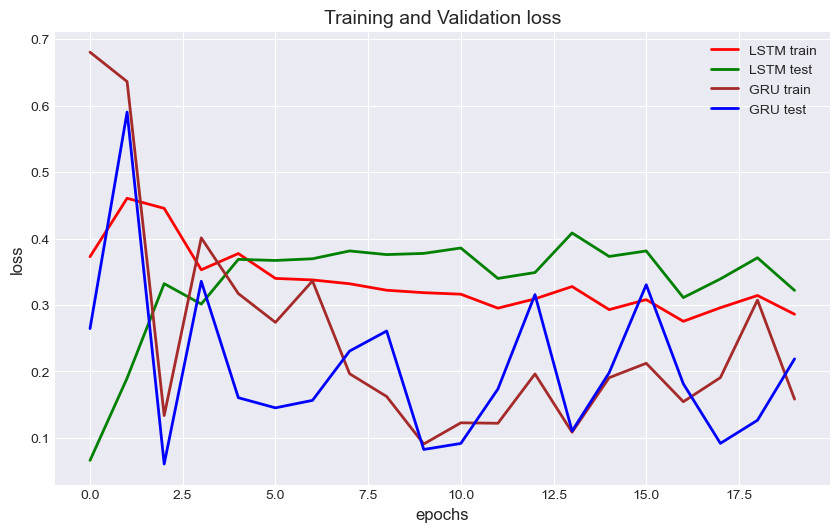

In [47]:
# plot models error 
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(history_lstm.history['loss'], label='LSTM train', color='red')
plt.plot(history_lstm.history['val_loss'], label='LSTM test', color= 'green')
plt.plot(gru_history.history['loss'], label='GRU train', color='brown')
plt.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()